<a href="https://colab.research.google.com/github/neyrinck/alphafold_chimerax/blob/main/alphafold_colab_batch_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Code to store the results of the alphafold/colabfold protein-folding code
## in Google Drive directories

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import subprocess
import numpy as np

# The following was to fix an error message that appeared once ... maybe not necessary
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

Mounted at /content/drive


In [ ]:
# The following entire cell was copied from the alphafold script ChimeraX runs.
# It's possible I made a small modification, but the raw ChimeraX script worked.

# ================================================================================================
# Google Colab code for running an AlphaFold structure prediction using ColabFold.
#
def run_prediction(sequences,
                   job_name = '',
                   msa_mode = "MMseqs2 (UniRef+Environmental)",
                   pair_mode = "unpaired+paired",
                   use_templates = False,
                   custom_template_path = None,
                   energy_minimize = False,
                   model_type = "auto",
                   num_recycles = 3,
                   dpi = 200,
                   install_log = 'install_log.txt',
                   result_dir ='.'):
    '''
    Installs alphafold if not yet installed and runs a stucture prediction.
    Model names ending in "_ptm" predict TM score ('model_1_ptm', ..., 'model_5_ptm').

    Parameters
    ----------
    msa_mode: "MMseqs2 (UniRef+Environmental)", "MMseqs2 (UniRef only)", "single_sequence", "custom"
    pair_mode: "unpaired+paired", "paired", "unpaired"
       "unpaired+paired" = pair sequences from same species + unpaired MSA
       "unpaired" = seperate MSA for each chain
       "paired" - only use paired sequences.
    model_type: "auto", "AlphaFold2-ptm", "AlphaFold2-multimer-v1", "AlphaFold2-multimer-v2"
       "auto" = protein structure prediction using "AlphaFold2-ptm" and complex prediction "AlphaFold-multimer-v2"
        For complexes "AlphaFold-multimer-v[1,2]" and "AlphaFold-ptm" can be used.
    dpi: dots-per-inch for saved plot images
    '''

    start_logging()

    use_amber = energy_minimize

    install(use_amber=use_amber, use_templates=use_templates, install_log=install_log)

    report_gpu_type()

    warn_about_sequence_length(sequences)

    remove_old_files()

    if not job_name:
        nres = sum(len(seq) for seq in sequences)
        job_name = 'af%d' % nres

    # Write sequences, used only for inclusion in returned results.
    with open('query.fasta', 'w') as seqs_file:
        seqs_file.write(''.join(f'>{i+1}\n{seq}\n' for i,seq in enumerate(sequences)))

    from pathlib import Path
    from colabfold import utils
    if not hasattr(utils, 'setup_logging_done'):
        utils.setup_logging(Path(".").joinpath("log.txt"))
        utils.setup_logging_done = True

    # Avoid various FutureWarning message from deprecated jax features
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

    query_sequence = ':'.join(sequences)
    queries_path=f"{job_name}.csv"
    with open(queries_path, "w") as text_file:
      text_file.write(f"id,sequence\n{job_name},{query_sequence}")

    from colabfold.batch import get_queries, set_model_type
    queries, is_complex = get_queries(queries_path)
    model_type = set_model_type(is_complex, model_type)

    if not(os.path.exists('params/download_complexes_multimer_v3_finished.txt')):
      from colabfold.download import download_alphafold_params
      download_alphafold_params(model_type, Path("."))

    from colabfold.batch import run
    run(
      queries=queries,
      result_dir=result_dir,
      use_templates=use_templates,
      custom_template_path=custom_template_path,
      use_amber=use_amber,
      msa_mode=msa_mode,
      model_type=model_type,
      num_models=5,
      num_recycles=num_recycles,
      model_order=[1, 2, 3, 4, 5],
      is_complex=is_complex,
      data_dir=Path("."),
      keep_existing_results=False,
      recompile_padding=1.0,
      rank_by="auto",
      pair_mode=pair_mode,
      stop_at_score=100.0,
      feature_dict_callback=plot_msa,
      prediction_callback=prediction_callback,
      dpi=dpi
    )

    #print('Downloading structure predictions to directory Downloads/ChimeraX/AlphaFold')
    #download_results(energy_minimize)

# ================================================================================================
#
def start_logging():
    msg = 'Please cite <a href="https://www.nature.com/articles/s41592-022-01488-1">ColabFold: Making protein folding accessible to all. Nature Methods (2022)</a> if you use these predictions.'
    from IPython.display import display, HTML
    display(HTML(msg))

    # Change logging to not show milliseconds
    import logging
    logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%-H:%M:%S')
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.INFO)

    import datetime
    logger.info('Starting prediction on %s UTC time'
                % datetime.datetime.utcnow().strftime('%Y-%m-%d'))

# ================================================================================================
#
def plot_msa(input_features, dpi=200):
    from colabfold.plot import plot_msa_v2
    plot_msa_v2(input_features, dpi=dpi)

# ================================================================================================
#
def prediction_callback(unrelaxed_protein, query_sequence_len_array,
                        prediction_result, input_features, type):
  import matplotlib.pyplot as plt
  multimer = (len(query_sequence_len_array) > 1)
  nplots = 3 if multimer else 2
  fig, axes = plt.subplots(1,nplots,figsize=(9,3), dpi=150)
  plot_protein(unrelaxed_protein, axes[0], coloring = 'plddt')
  from colabfold.colabfold import plot_pae
  plot_pae(prediction_result["predicted_aligned_error"], axes[1],
           Ls = query_sequence_len_array, colorkey_size = 0.9)
  axes[1].set_title("Predicted aligned error", pad=20)  # Add some padding to the caption.
  if multimer:
      plot_protein(unrelaxed_protein, axes[2], coloring = 'chain',
                   query_sequence_len_array=query_sequence_len_array)
  plt.show()
  plt.close()

# ================================================================================================
#
def plot_protein(protein, plot_axis, coloring='plddt', query_sequence_len_array = None,
                 best_view=True, line_w=2.0):
  import numpy as np
  pos = np.asarray(protein.atom_positions[:,1,:])
  plddt = np.asarray(protein.b_factors[:,0])

  from colabfold import colabfold
  colabfold.plot_protein_backbone(protein = protein, pos = pos, plddt = plddt,
                                  axes = plot_axis, coloring = coloring, Ls = query_sequence_len_array,
                                  best_view = best_view, line_w = line_w)

  if coloring == 'plddt':
    plot_axis.set_title('Colored by pLDDT')
  elif coloring == 'chain':
    plot_axis.set_title('Colored by chain')

# ================================================================================================
#
def download_results(energy_minimize):
  use_utf8_encoding()	# Work around preferred encoding bug.

  relax = 'relaxed' if energy_minimize else 'unrelaxed'
  !cp -p *_{relax}_rank_001_*.pdb best_model.pdb
  !cp -p *_scores_rank_001_*.json best_model_pae.json

  # Make a zip file of the predictions
  !zip -q -r results.zip query.fasta *.csv *.json *.a3m *.pdb cite.bibtex *.png *log.txt

  # Download predictions.
  from google.colab import files
  files.download('results.zip')

# ================================================================================================
#
def use_utf8_encoding():
  # Work-around bug where Conda/OpenMM changes the preferred encoding to ANSI breaking
  # Google Colab shell magic which requires UTF-8 encoding (January 17, 2023).
  # https://github.com/deepmind/alphafold/issues/483
  # https://www.rbvi.ucsf.edu/trac/ChimeraX/ticket/8313
  import locale
  if locale.getpreferredencoding() != 'UTF-8':
      locale.getpreferredencoding_orig = locale.getpreferredencoding
      def get_preferred_encoding_utf8(do_setlocale=True):
          return 'UTF-8'
      locale.getpreferredencoding = get_preferred_encoding_utf8

# ================================================================================================
#
def report_gpu_type():
  gpu_name_lines = !nvidia-smi --format=csv,noheader --query-gpu=name
  gpu_name = gpu_name_lines[0]
  print(f'Using {gpu_name} graphics processor')
  if gpu_name.startswith('Tesla K80'):
    if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
      import os
      del os.environ["TF_FORCE_UNIFIED_MEMORY"]
    if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
      import os
      del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

# ================================================================================================
#
def warn_about_sequence_length(sequences, warning_length = 1000):
    seq_len = sum([len(seq) for seq in sequences])
    if seq_len >= warning_length:
        print(f'Prediction may fail with total sequence length over {warning_length} residues due to limited GPU memory.\nPredicting {seq_len} residues.')

# ================================================================================================
#
def remove_old_files():
  '''
  Remove previous runs files otherwise they will not be overwritten because
  the file name contains both the rank number and model number.
  Also need to remove model_ and model_env directories otherwise errors
  occur if different sequences are run when computing MSA.
  '''
  !rm -rf *.pdb *.json *_ *_env *.zip *.csv *.png *.a3m *.fasta

# ================================================================================================
#
def install(use_amber = False, use_templates = False, install_log = 'install_log.txt'):

  from sys import version_info as vi
  python_version = f'{vi.major}.{vi.minor}'

  import logging
  logger = logging.getLogger(__name__)
  logger.info('Installing ColabFold on Google Colab virtual machine.')

  from os.path import exists
  if not exists('COLABFOLD_READY'):
    print ('Installing ColabFold')
    cmds = f'''
set -e
# We have to use "--no-warn-conflicts" because colab already has a lot preinstalled with requirements different to ours
pip install --no-warn-conflicts "colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold@dc9fc3d03379d23784e796f4c7fd31d173bafaa2"
# high risk high gain
pip uninstall jaxlib -y
pip install "jax[cuda11_cudnn805]==0.3.24" jaxlib==0.3.24+cuda11.cudnn805 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
touch COLABFOLD_READY
'''
    run_shell_commands(cmds, 'install_colabfold.sh', install_log)

  if (use_amber or use_templates) and not exists('CONDA_READY'):
    print('Installing Conda')
    cmds = f'''
# setup conda
set -e
wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
rm Miniconda3-latest-Linux-x86_64.sh
touch CONDA_READY
'''
    run_shell_commands(cmds, 'install_conda.sh', install_log)

  if use_templates and not exists('HH_READY'):
    print('Installing hhsuite')
    cmds = f'''
# setup template search
set -e
# Avoid updating conda since it can break openmm install. ChimeraX bug #9265.
conda config --set auto_update_conda false
conda install -y -q -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python={python_version} 2>&1 1>/dev/null
touch HH_READY
'''
    run_shell_commands(cmds, 'install_hhsuite.sh', install_log)

  if use_amber and not exists('AMBER_READY'):
    print('Installing OpenMM')
    cmds = f'''
# setup openmm for amber refinement
set -e
conda install -y -q -c conda-forge openmm=7.7.0 python={python_version} pdbfixer 2>&1 1>/dev/null
# Make colab python find conda openmm and pdbfixer
ln -s /usr/local/lib/python{python_version}/site-packages/simtk .
ln -s /usr/local/lib/python{python_version}/site-packages/openmm .
ln -s /usr/local/lib/python{python_version}/site-packages/pdbfixer .
touch AMBER_READY
'''
    run_shell_commands(cmds, 'install_openmm.sh', install_log)

  # Enable colabfold logging from batch module.
  from colabfold.batch import logger as colabfold_logger
  import logging
  colabfold_logger.setLevel(logging.INFO)

# ================================================================================================
#
def run_shell_commands(commands, filename, install_log):
  with open(filename, 'w') as f:
    f.write(commands)

  # The -x option logs each command with a prompt in front of it.
  !bash -x "{filename}" >> "{install_log}" 2>&1
  if _exit_code != 0:
    raise RuntimeError('Error running shell script %s, output in log file %s'
                       % (filename, install_log))

# ================================================================================================
#
def remove_from_list(list, item):
  '''Remove an item from a list. Return true if removed otherwise false.'''
  try:
    list.remove(item)
    return True
  except ValueError:
    return False

AA163 1183
['MVVSAGPLSSEKAEMNILEINEKLRPQLAEKKQQFRNLKEKCFLTQLAGFLANRQKKYKYEECKDLIKFMLRNERQFKEEKLAEQLKQAEELRQYKVLVHAQERELTQLREKLREGRDASRSLNEHLQALLTPDEPDKSQGQDLQEQLAEGCRLTQHLVQKLSPENDNDDDEDVQVEVAEKVQKSSAPREMQKAEEKEVPEDSLEECAITCSNSHGPYDSNQPHKKTKITFEEDKVDSTLIGSSSHVEWEDAVHIIPENESDDEEEEEKGPVSPRNLQESEEEEVPQESWDEGYSTLSIPPEMLASYQSYSSTFHSLEEQQVCMAVDIGRHRWDQVKKEDQEATGPRLSRELLDEKEPEVLQDSLDRCYSTPSGCLELTDSCQPYRSAFYVLEQQRVGLAIDMDEIEKYQEVEEDQDPSCPRLSRELLDEKEPEVLQDSLDRCYSTPSDYLELPDLGQPYSSAVYSLEEQYLGLALDVDRIKKDQEEEEDQGPPCPRLSRELLEVVEPEVLQDSLDRCYSTPSSCLEQPDSCQPYGSSFYALEEKHVGFSLDVGEIEKKGKGKKRRGRRSKKKR', 'MKWVTFISLLFLFSSAYSRGVFRRDAHKSEVAHRFKDLGEENFKALVLIAFAQYLQQCPFEDHVKLVNEVTEFAKTCVADESAENCDKSLHTLFGDKLCTVATLRETYGEMADCCAKQEPERNECFLQHKDDNPNLPRLVRPEVDVMCTAFHDNEETFLKKYLYEIARRHPYFYAPELLFFAKRYKAAFTECCQAADKAACLLPKLDELRDEGKASSAKQRLKCASLQKFGERAFKAWAVARLSQRFPKAEFAEVSKLVTDLTKVHTECCHGDLLECADDRADLAKYICENQDSISSKLKECCEKPLLEKSHCIAEVENDEMPADLPSLAADFVESKDVCKNYAEAKDVFLGMFLYEYARRHPDYSVVLLLRLAKTYETTLEKCCAAADPHECYAKVFDEFKPLVEEPQ

INFO:__main__:Starting prediction on 2023-11-06 UTC time
INFO:__main__:Installing ColabFold on Google Colab virtual machine.


Installing ColabFold
Using Tesla T4 graphics processor
Prediction may fail with total sequence length over 1000 residues due to limited GPU memory.
Predicting 1183 residues.


2023-11-06 22:07:08,968 Running on GPU
2023-11-06 22:07:09,237 Found 4 citations for tools or databases
2023-11-06 22:07:09,237 Query 1/1: af1183 (length 1183)


COMPLETE: 100%|██████████| 300/300 [elapsed: 00:00 remaining: 00:00]


2023-11-06 22:07:12,115 Setting max_seq=508, max_extra_seq=2048
2023-11-06 22:14:29,314 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=54.3 pTM=0.546 ipTM=0.245
2023-11-06 22:21:06,448 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=56.2 pTM=0.569 ipTM=0.601 tol=12.2
2023-11-06 22:27:43,309 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=56.3 pTM=0.572 ipTM=0.64 tol=8.02
2023-11-06 22:34:20,386 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=56.3 pTM=0.569 ipTM=0.641 tol=5.52
2023-11-06 22:34:20,388 alphafold2_multimer_v3_model_1_seed_000 took 1623.4s (3 recycles)


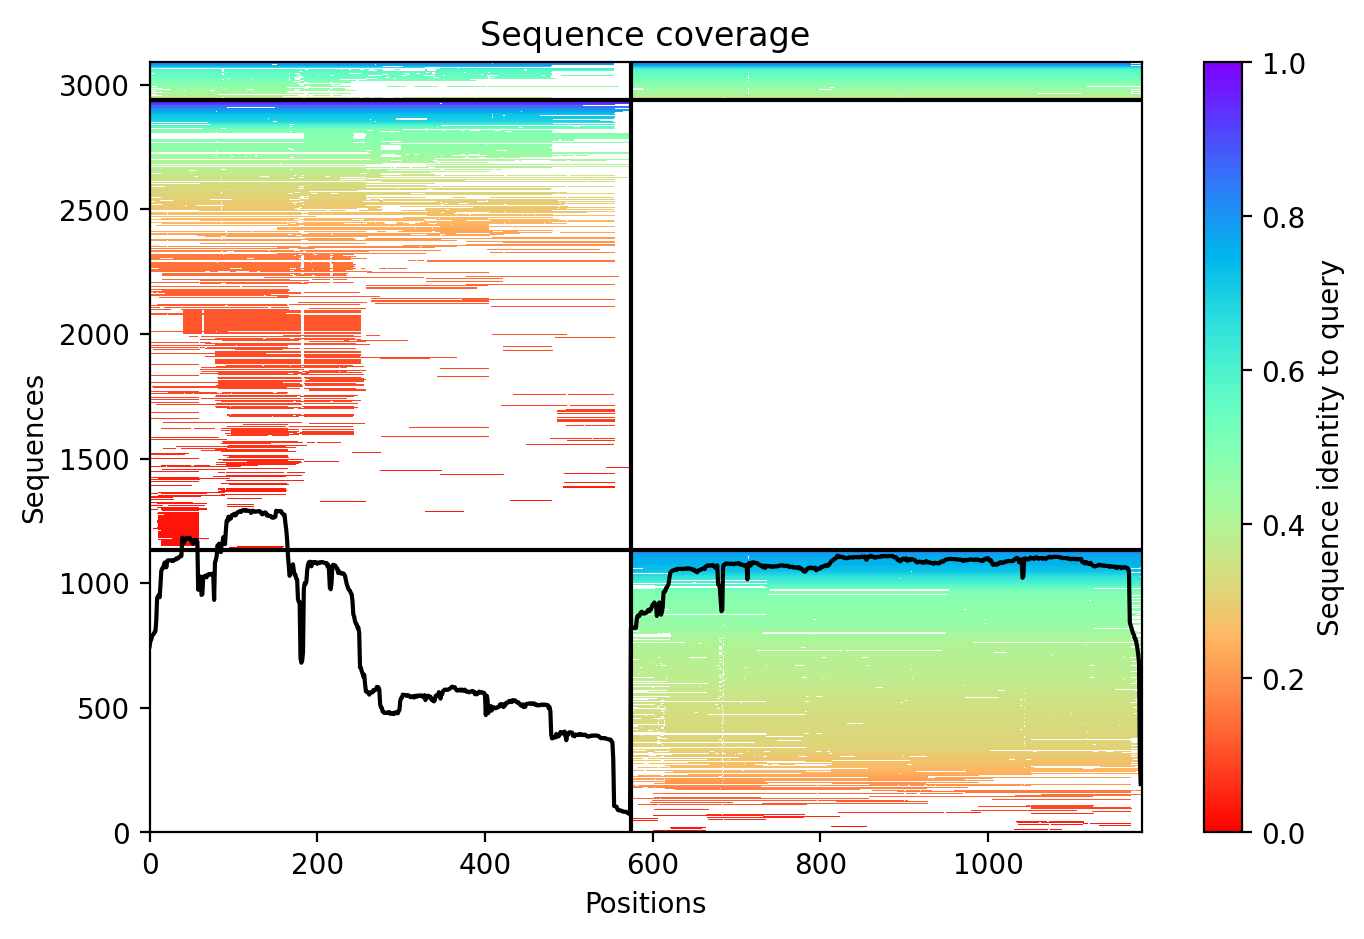

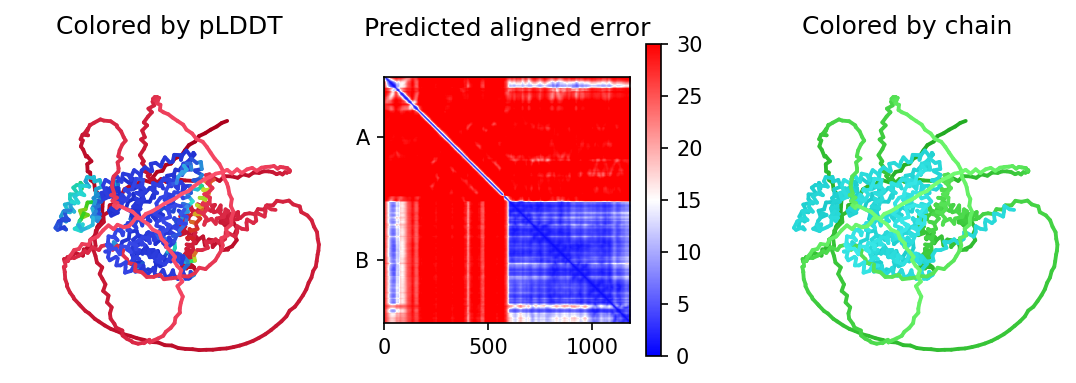

2023-11-06 22:41:00,194 alphafold2_multimer_v3_model_2_seed_000 recycle=0 pLDDT=55.3 pTM=0.546 ipTM=0.235
2023-11-06 22:47:37,161 alphafold2_multimer_v3_model_2_seed_000 recycle=1 pLDDT=57.3 pTM=0.566 ipTM=0.583 tol=17.5
2023-11-06 22:54:14,137 alphafold2_multimer_v3_model_2_seed_000 recycle=2 pLDDT=58 pTM=0.571 ipTM=0.669 tol=7.46


In [ ]:
# ================================================================================================
# go through rows and columns, and predict structures for each sequence.


# These have rows and columns as in the Google Sheets spreadsheet,
# "Copy of DUFD1220, OLD, domains--ion channels, joined sequences"
# at https://docs.google.com/spreadsheets/d/1V8xlqQR-274ngJ9DpM146BOkYxmOg-Oug7W3mZUMKr4/edit?usp=sharing

rowfile = '/content/drive/MyDrive/proteins/row_sequences.txt'
colfile = '/content/drive/MyDrive/proteins/column_sequences.txt'

with open(rowfile) as Frow:
  rows = Frow.read().splitlines()
  with open(colfile) as Fcol:
    cols = Fcol.read().splitlines()
    for icol in np.arange(0,len(cols)):
      colline = cols[icol].strip()
      for irow in range(len(rows)):
        # exclude the corner of models already run by Howard/Tim
        if (icol < 9) & (irow < 37):
          continue
        rowline = rows[irow].strip()
        # Limit on total length of sequence. According to warnings, limit should
        # be 1000, but we've run longer, up to 1200
        if (len(rowline)+len(colline) <= 1200):

#        if (irow >= 36)
#        if (len(rowline) <= 800):
          seq_list = [colline,rowline]
          dont_minimize = remove_from_list(seq_list, 'dont_minimize')		# Energy minimization
          use_templates = remove_from_list(seq_list, 'use_pdb_templates')

          # code to translate the column number 0... to letter/letters.
          # "irow+110" translates row number starting with 0 to row number
          # starting with 110.
          if icol > 6:
            # 7,8,...  -> AA,AB,...
            cell = 'A%s%03d'%(chr(icol+64-6),irow+110)
          else:
            # 0,1,2,3,4,5,6 -> T,U,V,W,X,Y,Z
            cell = '%s%03d'%(chr(icol+64+20),irow+110)
          if not(os.path.exists('/content/drive/MyDrive/proteins/%s/done.txt'%cell)):
            # if not already done according to this script
            print(cell,len(rowline)+len(colline))
            print(seq_list)

            os.system('mkdir /content/drive/MyDrive/proteins/%s/'%cell)

            # The meat of the run; runs code from previous long cell
            run_prediction(seq_list, use_templates = use_templates,
                          energy_minimize = False,#not dont_minimize,
                          result_dir='/content/drive/MyDrive/proteins/'+cell)

            #copy log files, and top rank to best_model
            os.system('cp *.csv log.txt /content/drive/MyDrive/proteins/'+cell)
            os.system('cp /content/drive/MyDrive/proteins/%s/*unrelaxed_rank_001*.pdb /content/drive/MyDrive/proteins/%s/best_model.pdb'%(cell,cell))
            os.system('cp /content/drive/MyDrive/proteins/%s/*scores_rank_001*.json /content/drive/MyDrive/proteins/%s/best_model_pae.json'%(cell,cell))

            #mark as done
            os.system('touch /content/drive/MyDrive/proteins/%s/done.txt'%cell)